# Coin Detection Module: Exploration and Justification
In this notebook, we will break down our image detection pipeline step by step. 
The goal is to visualize the impact of each transformation and justify our parameter choices (such as using Adaptive Thresholding rather than the classic Otsu method).

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Fonction générique pour comparer plusieurs images côte à côte
def plot_comparison(images, titles, figsize=(18, 5)):
    """Affiche une liste d'images avec leurs titres correspondants."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    # Sécurité si on n'affiche qu'une seule image
    if n == 1: 
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # Si l'image est en couleur (BGR), on la passe en RGB pour Matplotlib
        if len(img.shape) == 3:
            img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
        else:
            # Sinon on l'affiche en nuances de gris
            ax.imshow(img, cmap='gray')
            
        ax.set_title(title, fontsize=14)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Création de l'instance de notre classe (pas besoin d'instancier tout le code ici, 
# on va faire les étapes à la main pour bien les voir)
target_width = 800

### 1. Prétraitement et Chargement de l'image

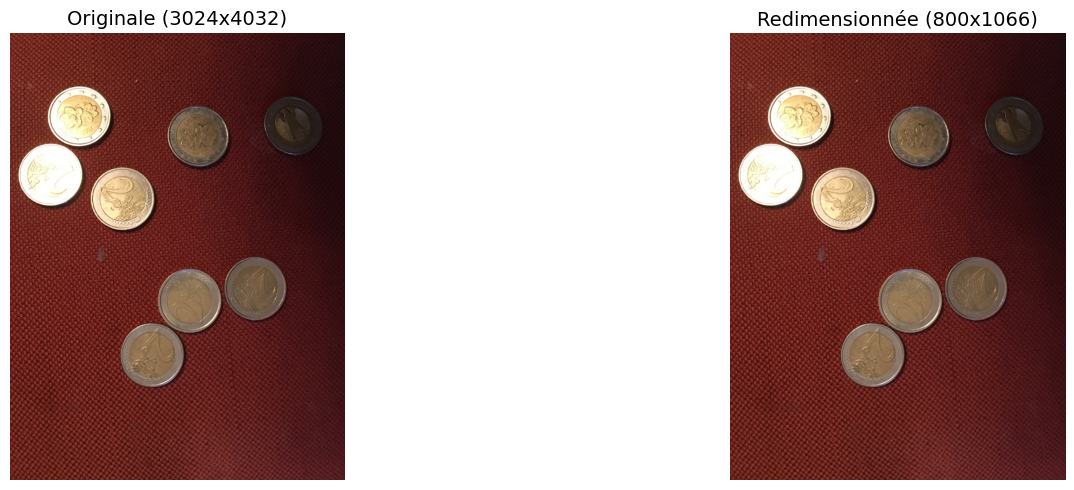

In [99]:
img_path = './data/gp3/3_6.jpg' 
img_original = cv2.imread(img_path)

if img_original is None:
    print(f"Erreur: Impossible de charger l'image {img_path}")
else:
    # 1. Redimensionnement (Preprocess)
    h, w = img_original.shape[:2]
    scale = target_width / w
    new_h = int(h * scale)
    img_resized = cv2.resize(img_original, (target_width, new_h), interpolation=cv2.INTER_AREA)

    plot_comparison([img_original, img_resized], 
                    [f'Originale ({w}x{h})', f'Redimensionnée ({target_width}x{new_h})'])

### 2. Pourquoi utiliser le flou (Blur) et le CLAHE ?
Avant de créer notre masque binaire, nous passons l'image en niveaux de gris. 
- **CLAHE** permet d'équilibrer la lumière locale (récupère les pièces dans l'ombre).
- **Le flou gaussien (13x13)** est crucial : sans lui, l'algorithme de segmentation va essayer de détourer les étoiles et les visages *à l'intérieur* des pièces.

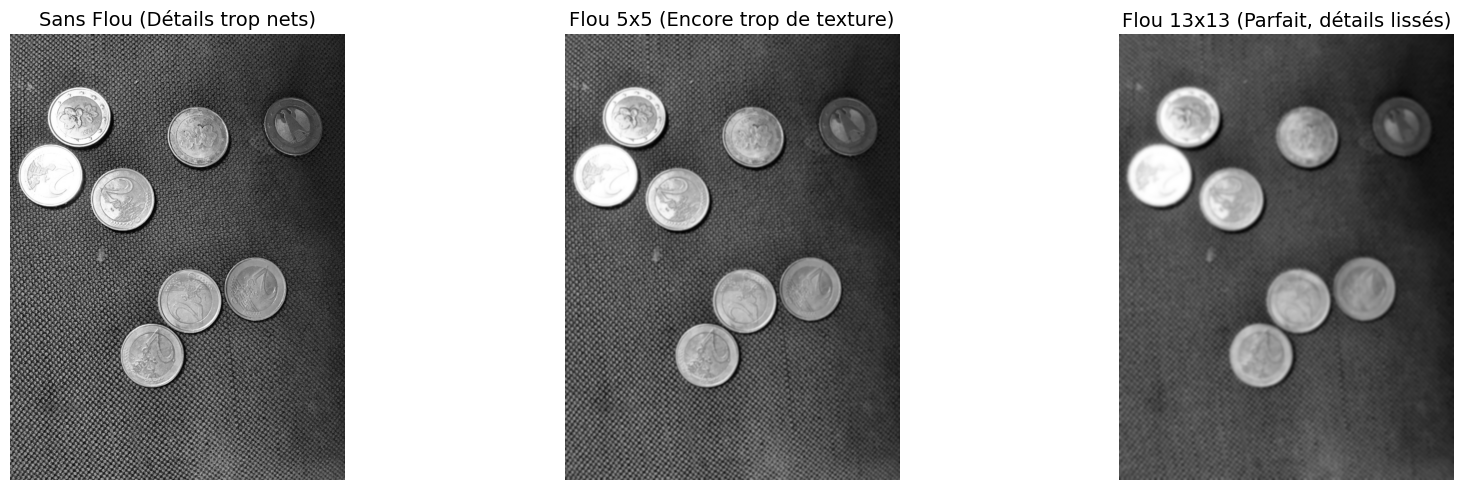

In [ ]:
gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

# Application du CLAHE
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Comparaison des niveaux de flou
blur_none = enhanced
blur_small = cv2.GaussianBlur(enhanced, (7, 7), 0)
blur_heavy = cv2.GaussianBlur(enhanced, (13, 13), 3) # Notre choix !

plot_comparison(
    [blur_none, blur_small, blur_heavy], 
    ['Sans Flou (Détails trop nets)', 'Flou 5x5 (Encore trop de texture)', 'Flou 13x13 (Parfait, détails lissés)']
)

### 3. Segmentation : Otsu Global vs Adaptive Threshold
C'est ici que l'on justifie notre choix majeur. 
La méthode d'Otsu trouve un seuil unique pour toute l'image. 

Si l'image a une moitié à l'ombre et une moitié au soleil, Otsu échoue. 

L'**Adaptive Threshold** calcule un seuil dynamique pour chaque petite région de 21x21 pixels.

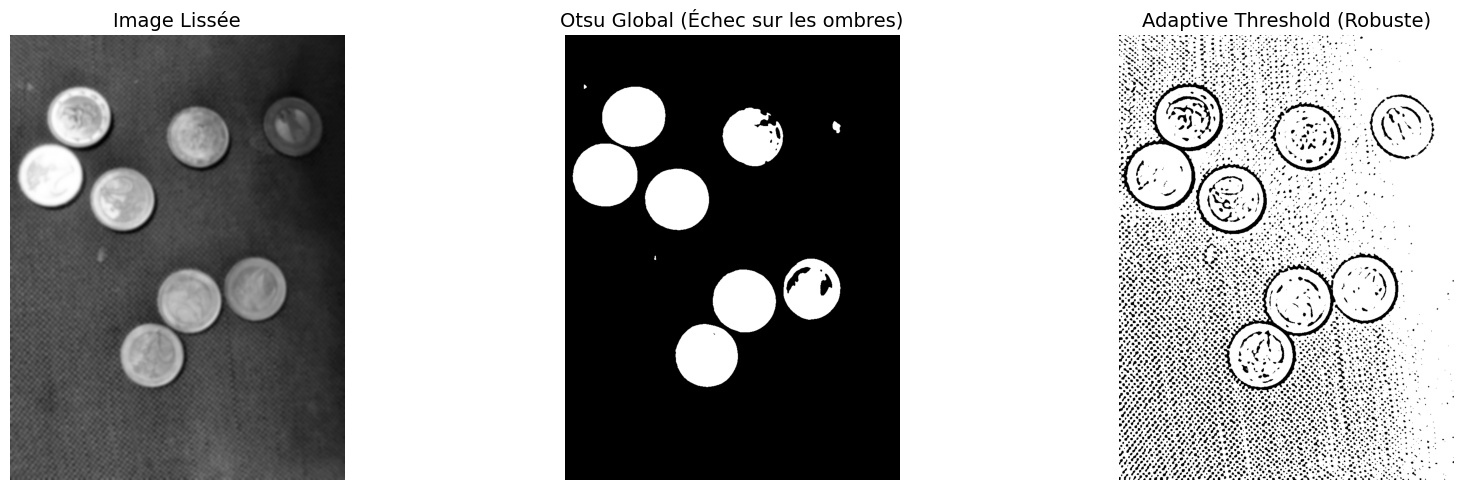

In [123]:
# 1. Test avec Otsu Global (Ce qu'on ne veut PAS utiliser pour les fonds neutres)
_, mask_otsu = cv2.threshold(blur_heavy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Note: on inverse souvent (THRESH_BINARY_INV) si le fond est clair. 
# Pour l'exemple, on suppose un fond sombre (is_light=False).
_, mask_otsu_inv = cv2.threshold(blur_heavy, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 2. Test avec notre Adaptive Threshold
mask_adaptive = cv2.adaptiveThreshold(
    blur_heavy, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, # ou THRESH_BINARY_INV selon is_light
    21, 4
)

plot_comparison(
    [blur_heavy, mask_otsu, mask_adaptive], 
    ['Image Lissée', 'Otsu Global (Échec sur les ombres)', 'Adaptive Threshold (Robuste)']
)

### 4. Nettoyage Morphologique
Le masque généré par l'Adaptive Threshold est souvent bruité (petits points noirs dans les pièces, ou poussières blanches dans le fond). Nous utilisons `MORPH_CLOSE` pour boucher les trous internes, et `MORPH_OPEN` pour effacer les poussières externes.

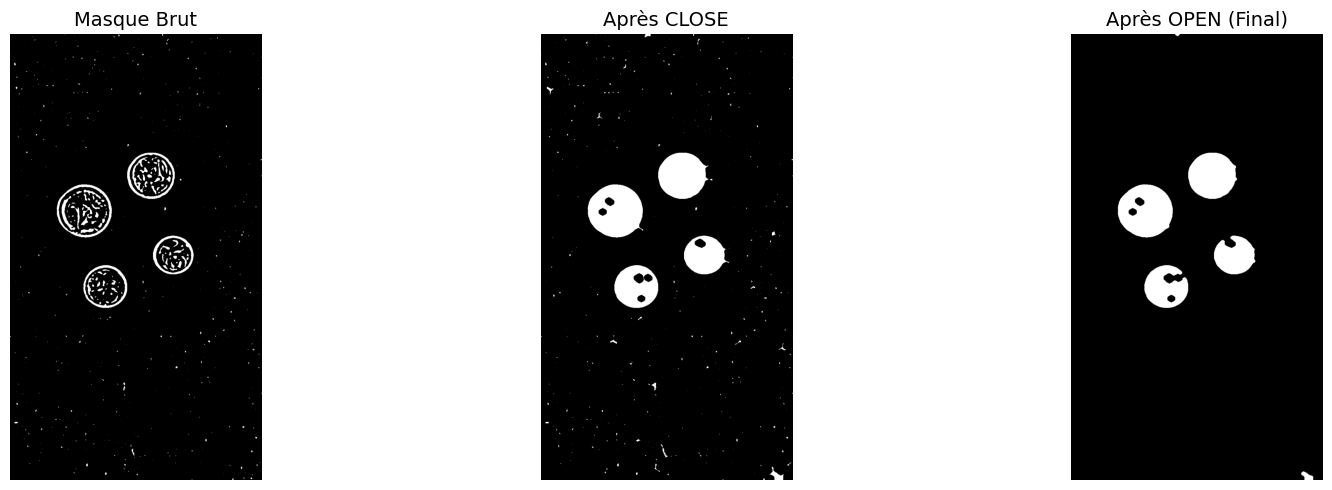

In [173]:
# 1. Filtre CLAHE : Vital pour faire ressortir les pièces dans l'ombre ou le camouflage
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
gray_clahe = clahe.apply(gray_val) # Assure-toi d'utiliser ton image en niveaux de gris ici

# 2. Flou Gaussien : Vital pour effacer les gravures des pièces (étoiles, visages)
blurred = cv2.GaussianBlur(gray_clahe, (13, 13), 3)

# 3. Le fameux Adaptive Threshold
# ATTENTION AU PARAMÈTRE : Si le fond est CLAIR, utilise cv2.THRESH_BINARY_INV
#                          Si le fond est SOMBRE, utilise cv2.THRESH_BINARY
mask_adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY_INV, # <-- Change ceci en cv2.THRESH_BINARY si l'image reste noire
                                      21, 4)

# 4. Nettoyage Morphologique
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask_closed = cv2.morphologyEx(mask_adaptive, cv2.MORPH_CLOSE, kernel, iterations=4)
mask_final = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel, iterations=2)

plot_comparison(
    [mask_adaptive, mask_closed, mask_final], 
    ['Masque Brut', 'Après CLOSE', 'Après OPEN (Final)']
)

### 5. Cas spécial : Les fonds très colorés (Stratégie de Saturation)
Si notre analyse détecte un fond rouge, bleu ou vert très vif, les méthodes basées sur les nuances de gris échouent (une pièce grise sur un fond bleu foncé ont la même "luminosité"). 
Nous utilisons alors le canal de **Saturation** (les pièces en métal n'ont aucune saturation, contrairement au fond).

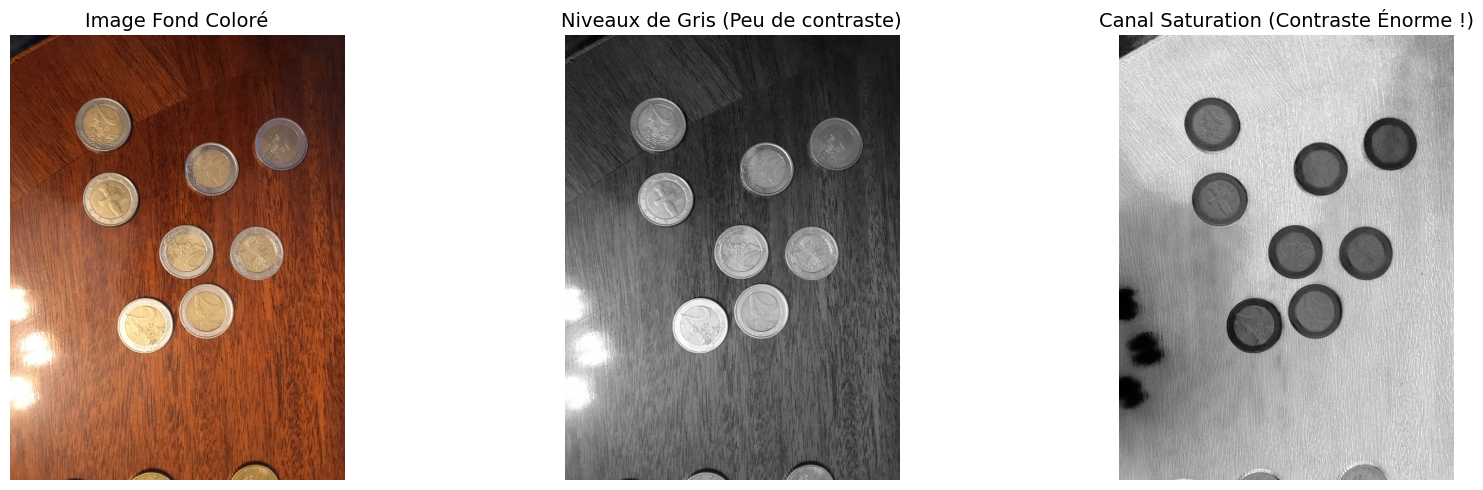

In [174]:
# REMPLACE par une image avec un fond très coloré (ex: nappe rouge, bureau bleu)
img_color_path = './data/gp3/3_7.jpg' 
img_color = cv2.imread(img_color_path)

img_color = cv2.resize(img_color, (target_width, int(img_color.shape[0] * (target_width/img_color.shape[1]))))

# Extraction du canal Gris vs Saturation
gray_fail = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
saturation = hsv[:, :, 1] # Le métal sera très noir (0), le fond très blanc (255)

plot_comparison(
    [img_color, gray_fail, saturation], 
    ['Image Fond Coloré', 'Niveaux de Gris (Peu de contraste)', 'Canal Saturation (Contraste Énorme !)']
)

### 6. La Validation (Le "Videur")
Même avec les meilleurs paramètres, nos algorithmes (Hough, Contours) vont inévitablement détecter de faux cercles (un motif rond sur la table, une tache, etc.). 
Pour éviter ça, nous avons créé la méthode `_validate_fast` qui fait passer deux tests physiques à chaque cercle candidat.

**Pré-calcul pour la performance :**
Au lieu de recalculer les filtres pour chaque candidat (ce qui prendrait des minutes), nous calculons une seule fois la carte des contours nets (Canny Edge) sur toute l'image.

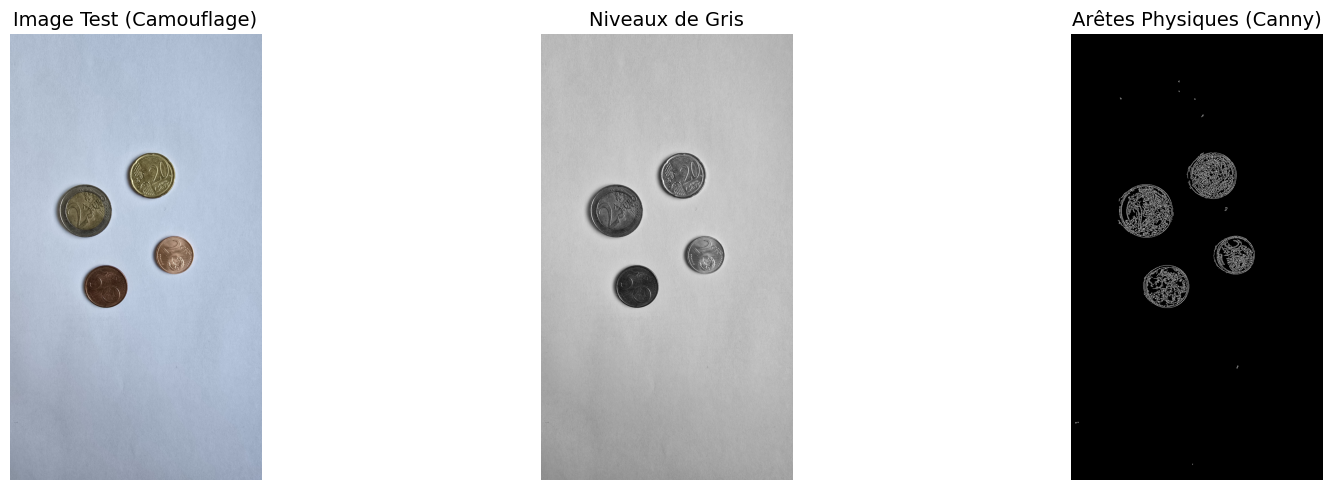

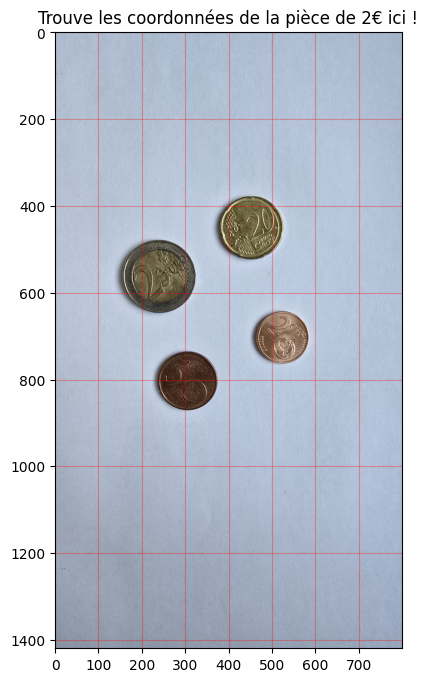

In [175]:
img_val_path = './data/gp4/2.jpg' 
img_val_original = cv2.imread(img_val_path)

# 1. On refait le preprocessing rapide pour cette nouvelle image
h, w = img_val_original.shape[:2]
scale = target_width / w
img_val = cv2.resize(img_val_original, (target_width, int(h * scale)), interpolation=cv2.INTER_AREA)

# 2. Pré-calcul pour la validation : Niveaux de gris et Canny
gray_val = cv2.cvtColor(img_val, cv2.COLOR_BGR2GRAY)

# Seuils 50/150 standards pour détecter les arêtes métalliques
edges_val = cv2.Canny(gray_val, 50, 150)

plot_comparison(
    [img_val, gray_val, edges_val], 
    ['Image Test (Camouflage)', 'Niveaux de Gris', 'Arêtes Physiques (Canny)']
)

# Affiche l'image en grand avec les axes (en pixels)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_val, cv2.COLOR_BGR2RGB))
plt.title("Trouve les coordonnées de la pièce de 2€ ici !")
plt.grid(True, color='red', alpha=0.3) # Ajoute une grille pour t'aider
plt.show()

### Le Test 1 : Le "Donut Test" (Contraste de Couleur)
Ce test vérifie si la zone **à l'intérieur** du cercle a une couleur différente de la zone **immédiatement à l'extérieur**.
- **Masque interne :** On prend 70% du rayon pour ne lire que le métal (et ignorer l'ombre du bord).
- **Masque externe (Donut) :** On prend une couronne de 100% à 120% du rayon pour lire le fond immédiat.
Si la différence moyenne de gris entre les deux est > 15, on valide la pièce.

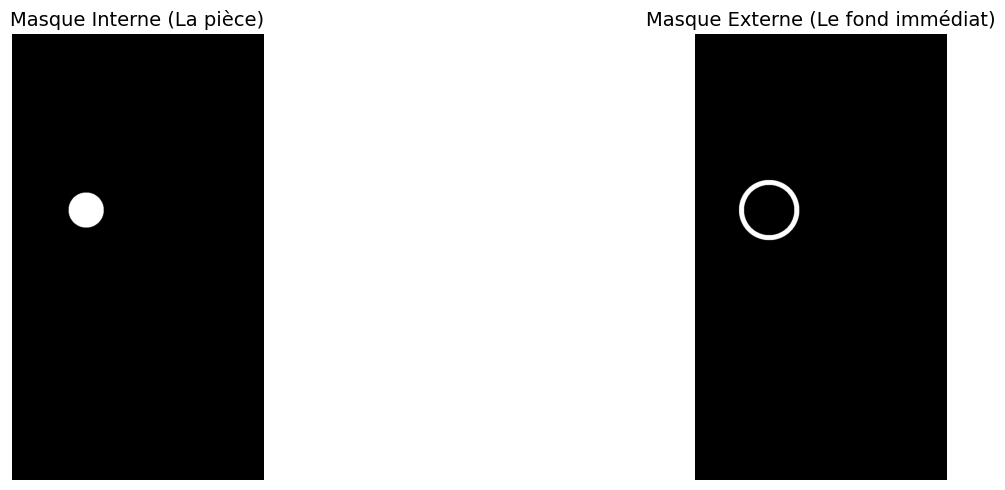

Couleur moyenne interne : 96.2
Couleur moyenne externe : 152.0
Différence de contraste local : 55.80
Validation Donut réussie (> 15) ? OUI


In [201]:
h_val, w_val = gray_val.shape[:2]

# On simule un cercle candidat (remplace x, y par les coordonnées d'une pièce de ton image test)
x, y, r = 235, 560, 80

# 1. Masque interne (70% du rayon)
mask_in = np.zeros((h_val, w_val), dtype=np.uint8)
cv2.circle(mask_in, (x, y), int(r * 0.7), 255, -1)

# 2. Masque externe (Couronne / Donut)
mask_out = np.zeros((h_val, w_val), dtype=np.uint8)
cv2.circle(mask_out, (x, y), int(r * 1.2), 255, -1)
cv2.circle(mask_out, (x, y), r, 0, -1) # On évide le centre

plot_comparison(
    [mask_in, mask_out], 
    ['Masque Interne (La pièce)', 'Masque Externe (Le fond immédiat)']
)

# Simulation du calcul OpenCV
mean_in = cv2.mean(gray_val, mask=mask_in)[0]
mean_out = cv2.mean(gray_val, mask=mask_out)[0]
diff_color = abs(mean_in - mean_out)

print(f"Couleur moyenne interne : {mean_in:.1f}")
print(f"Couleur moyenne externe : {mean_out:.1f}")
print(f"Différence de contraste local : {diff_color:.2f}")
print(f"Validation Donut réussie (> 15) ? {'OUI' if diff_color > 15 else 'NON (Passer au test 2)'}")

### Le Test 2 : Le Scénario du Camouflage (Canny Edge Score)
Que se passe-t-il si une pièce argentée est posée sur une table grise ? La différence de couleur (Donut Test) sera proche de zéro. La pièce serait faussement rejetée.

**La solution :** Une pièce de monnaie a une épaisseur physique (3D). Elle crée donc une micro-ombre sur son contour. On dessine le périmètre exact du cercle candidat (épaisseur 2 pixels) et on regarde s'il superpose des traits blancs sur notre carte `Canny`. Si le score est > 30, c'est un objet en relief, on valide !

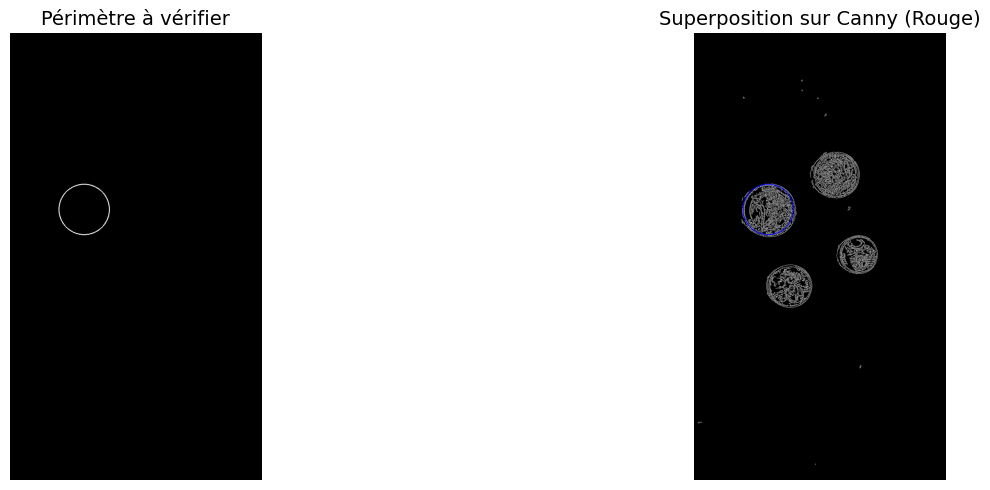

Score Canny Edge (Camouflage Test) : 77.99
Validation Edge réussie (> 30) ? OUI


In [202]:
# Masque du périmètre (épaisseur 2)
mask_edge = np.zeros((h_val, w_val), dtype=np.uint8)
cv2.circle(mask_edge, (x, y), r, 255, 2)

# On superpose visuellement notre masque de recherche sur la carte Canny
# (En rouge : le cercle géométrique qu'on cherche à valider)
canny_rgb = cv2.cvtColor(edges_val, cv2.COLOR_GRAY2RGB)
canny_rgb[mask_edge == 255] = [255, 0, 0] 

plot_comparison(
    [mask_edge, canny_rgb], 
    ['Périmètre à vérifier', 'Superposition sur Canny (Rouge)']
)

# Simulation du calcul : on fait la moyenne des pixels blancs de Canny qui tombent sous notre masque rouge
edge_score = cv2.mean(edges_val, mask=mask_edge)[0]

print(f"Score Canny Edge (Camouflage Test) : {edge_score:.2f}")
print(f"Validation Edge réussie (> 30) ? {'OUI' if edge_score > 30 else 'NON (C\'est une fausse détection)'}")

# Étape 5 : Les Algorithmes de Détection
Nous allons maintenant tester nos trois algorithmes : **Hough, Watershed et Contours**.
Pour bien voir leur utilité, chargeons une image où les pièces sont proches ou se touchent (ce qui fait généralement échouer les algorithmes simples).

*Note : Nous ajoutons une petite fonction utilitaire pour dessiner nos résultats plus facilement.*

In [203]:
# Fonction utilitaire pour dessiner les cercles sur une image
def draw_detected_coins(img, coins, color=(0, 255, 0), thickness=2):
    vis = img.copy()
    # Si c'est une image en niveaux de gris, on la passe en couleur pour voir nos dessins
    if len(vis.shape) == 2:
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2RGB)
        
    for c in coins:
        cv2.circle(vis, (c['x'], c['y']), c['r'], color, thickness)
        cv2.circle(vis, (c['x'], c['y']), 2, (255, 0, 0), -1) # Point central
    return vis

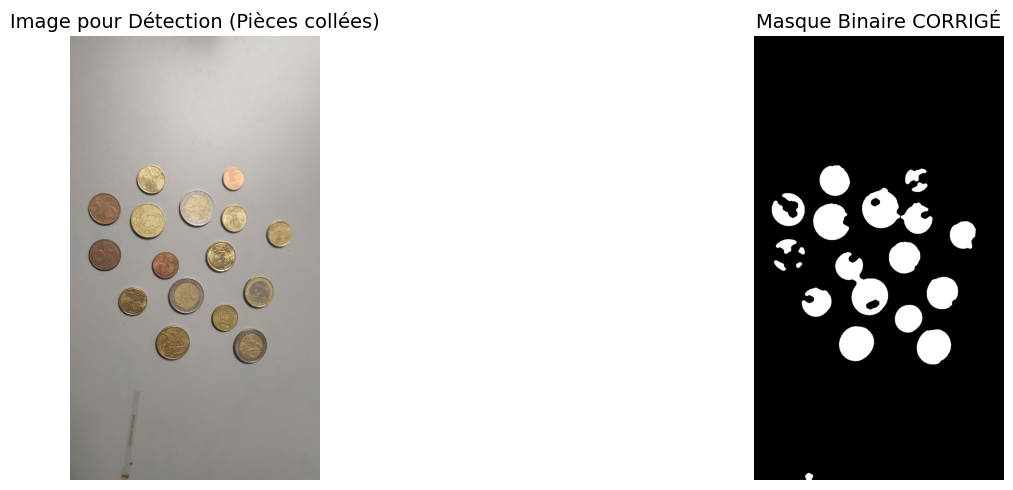

In [204]:
# Preprocessing rapide pour avoir nos variables de base
img_det_path = './data/gp5/12.jpg'
img_det_original = cv2.imread(img_det_path)

h, w = img_det_original.shape[:2]
img_det = cv2.resize(img_det_original, (target_width, int(h * (target_width/w))), interpolation=cv2.INTER_AREA)
gray_det = cv2.cvtColor(img_det, cv2.COLOR_BGR2GRAY)

# Génération du masque binaire
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
blur_det = cv2.GaussianBlur(clahe.apply(gray_det), (13, 13), 3)

# --- LA CORRECTION EST ICI ---
# On calcule vite fait si l'image est globalement claire ou sombre
is_light_bg = np.mean(gray_det) > 127
# Si c'est clair, on INVERSE (THRESH_BINARY_INV) pour que les pièces deviennent blanches !
thresh_type = cv2.THRESH_BINARY_INV if is_light_bg else cv2.THRESH_BINARY

binary_det = cv2.adaptiveThreshold(
    blur_det, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresh_type, 
    21, 4
)
# -----------------------------

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
binary_det = cv2.morphologyEx(binary_det, cv2.MORPH_CLOSE, kernel, iterations=4)
binary_det = cv2.morphologyEx(binary_det, cv2.MORPH_OPEN, kernel, iterations=2)

plot_comparison(
    [img_det, binary_det], 
    ['Image pour Détection (Pièces collées)', 'Masque Binaire CORRIGÉ']
)

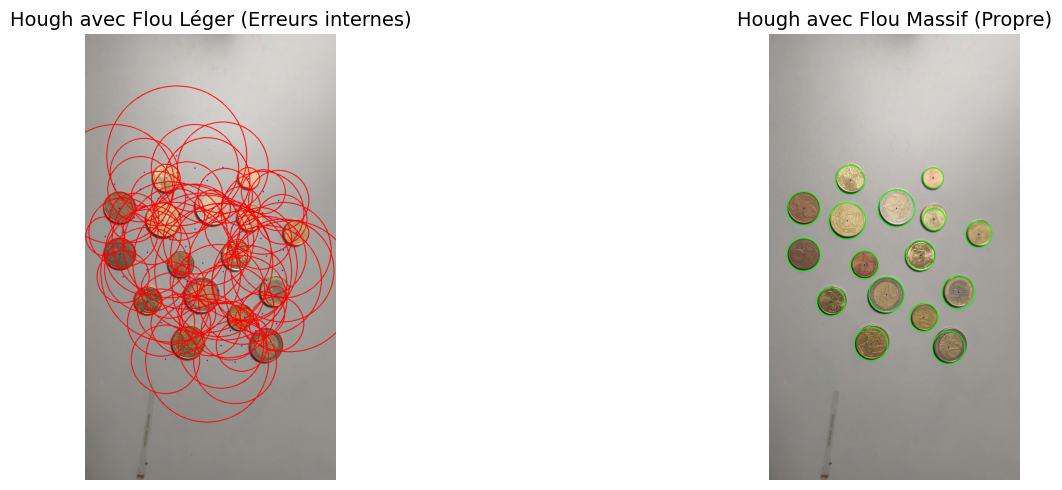

In [205]:
# 1. Image avec un léger flou (Ce qu'il ne faut pas faire)
gray_light_blur = cv2.GaussianBlur(clahe.apply(gray_det), (5, 5), 0)

# 2. Image avec notre flou massif (Ce que fait notre code)
gray_heavy_blur = cv2.GaussianBlur(clahe.apply(gray_det), (15, 15), 3)

# Paramètres de base pour Hough
min_r, max_r = 22, int(min(img_det.shape[:2]) * 0.28)
min_dist = max(int(min_r * 2.1), 55)

# Test sur le flou léger
circles_light = cv2.HoughCircles(gray_light_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=min_dist, param1=100, param2=45, minRadius=min_r, maxRadius=max_r)
coins_light = [{'x': int(c[0]), 'y': int(c[1]), 'r': int(c[2])} for c in np.round(circles_light[0])] if circles_light is not None else []

# Test sur le flou lourd
circles_heavy = cv2.HoughCircles(gray_heavy_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=min_dist, param1=100, param2=45, minRadius=min_r, maxRadius=max_r)
coins_heavy = [{'x': int(c[0]), 'y': int(c[1]), 'r': int(c[2])} for c in np.round(circles_heavy[0])] if circles_heavy is not None else []

plot_comparison(
    [draw_detected_coins(img_det, coins_light, (0,0,255)), draw_detected_coins(img_det, coins_heavy, (0,255,0))], 
    ['Hough avec Flou Léger (Erreurs internes)', 'Hough avec Flou Massif (Propre)']
)

### Méthode 2 : L'Algorithme de Watershed (Ligne de partage des eaux)
**Watershed résout le problème des pièces qui se touchent.**

Il calcule la distance entre chaque pixel blanc et le fond noir. Le centre de la pièce devient un "pic" d'intensité. On coupe ces pics, et on inonde l'image à partir de ces centres pour créer des barrages entre les pièces.

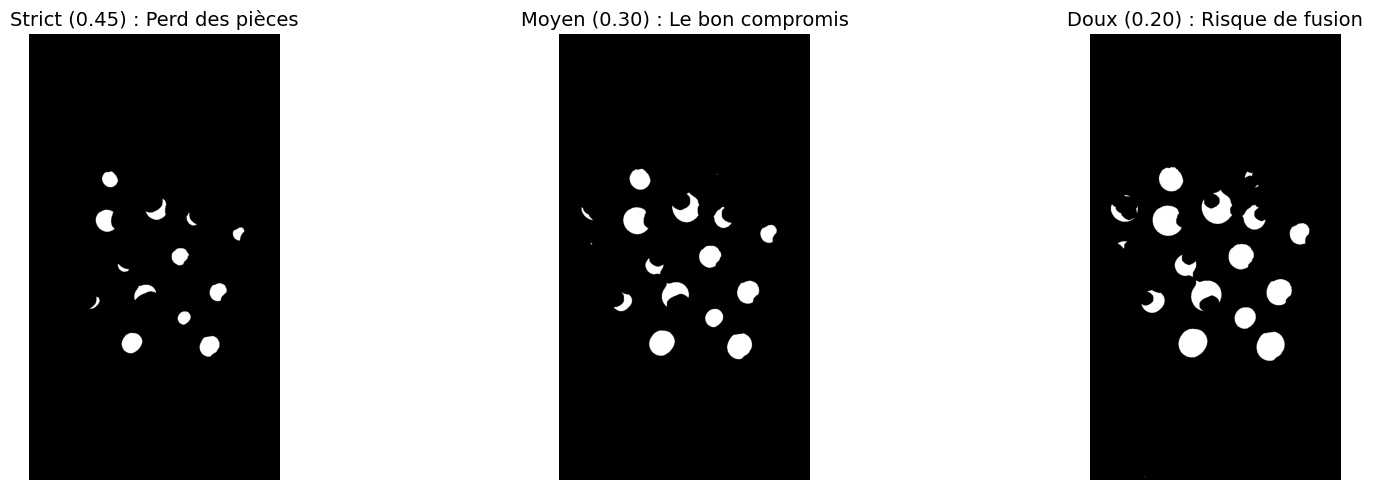

In [206]:
# 1. Transformée de distance (Topographie)
dist = cv2.distanceTransform(binary_det, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

# 2. On teste 3 seuils différents pour trouver le réglage parfait
# L'objectif est de garder les petites pièces sans que les centres fusionnent.
thresh_strict  = 0.45 * dist_norm.max() # L'ancien réglage (trop dur)
thresh_medium  = 0.30 * dist_norm.max() # Réglage intermédiaire
thresh_lenient = 0.20 * dist_norm.max() # Réglage très permissif

_, sure_fg_strict  = cv2.threshold(dist_norm, thresh_strict, 1.0, 0)
_, sure_fg_medium  = cv2.threshold(dist_norm, thresh_medium, 1.0, 0)
_, sure_fg_lenient = cv2.threshold(dist_norm, thresh_lenient, 1.0, 0)

# On affiche les 3 résultats côte à côte pour comparer
plot_comparison(
    [sure_fg_strict, sure_fg_medium, sure_fg_lenient], 
    [f'Strict (0.45) : Perd des pièces', 
     f'Moyen (0.30) : Le bon compromis', 
     f'Doux (0.20) : Risque de fusion']
)